In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

# Data extraction : sport quotes & occupation of the speakers

In [ ]:
# Load dataset containing sport quotes
quotes_directory = 'out_bz2'
sport_quotes_2015 = pd.read_csv(quotes_directory + '/sport-quotes-2015.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2016 = pd.read_csv(quotes_directory + '/sport-quotes-2016.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2017 = pd.read_csv(quotes_directory + '/sport-quotes-2017.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2018 = pd.read_csv(quotes_directory + '/sport-quotes-2018.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2019 = pd.read_csv(quotes_directory + '/sport-quotes-2019.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2020 = pd.read_csv(quotes_directory + '/sport-quotes-2020.csv.bz2', compression='bz2', usecols=['qids'])

df_all = pd.concat([sport_quotes_2015, sport_quotes_2016, sport_quotes_2017, sport_quotes_2018, sport_quotes_2019, sport_quotes_2020])
df_all.reset_index(inplace=True, drop=True)
df_all.head()

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('speaker_attributes.parquet', columns=['party', 'occupation', 'id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')


In [ ]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
df_all['qids'] = df_all['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(df_all['qids'])]
speakers 



# Data extraction : politicians sport quotes & party of politicians

In [2]:
#loading quotes dataset

df_2015 = pd.read_csv('quotes_by_politicians_2015.csv')
df_2016 = pd.read_csv('quotes_by_politicians_2016.csv')
df_2017 = pd.read_csv('quotes_by_politicians_2017.csv')
df_2018 = pd.read_csv('quotes_by_politicians_2018.csv')
df_2019 = pd.read_csv('quotes_by_politicians_2019.csv')
df_2020 = pd.read_csv('quotes_by_politicians_2020.csv')

df = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020])
df.reset_index(inplace=True, drop=True)
df.head()

,index_q,quoteID,quotation,speaker,qids,date
0,0,2015-08-03-026031,I am not a poster child for the Christie admin...,Bill Pascrell,Q529090,2015-08-03 17:44:16
1,1,2015-08-03-002773,Accidents occur where the street meets the rai...,Bill Pascrell,Q529090,2015-08-03 17:44:16
2,2,2015-02-26-089365,These federal investments will go a long way t...,Bill Pascrell,Q529090,2015-02-26 07:55:10
3,3,2015-02-14-027291,"Looking back, it seems that every several mont...",Bill Pascrell,Q529090,2015-02-14 00:12:20
4,4,2015-08-03-088419,This is just one of many crossings that need i...,Bill Pascrell,Q529090,2015-08-03 17:44:16


In [61]:
import json

class JsonObject:
    """
    Class that represents a JSON object
    Attributes:
      - params: dict[str, str]
            JSON object in one of its string forms
    """

    def __init__(self, params: dict):
        self.json = params

    def prettyFormat(self):
        """Generates a pretty printable string representation of the JSON object"""
        return json.dumps(self.json, indent = 4, sort_keys = True)

    def prettyPrint(self):
        """Pretty prints the JSON object"""
        print(self.prettyFormat())


In [62]:
from collections import deque

class Cache:
    """Represents a simple variable size cache"""

    def __init__(self, max_size: int):
        self.size = 0
        self.cache_max_size = max_size

        self.keys = deque(list(), max_size)
        self.map = dict()

    def add(self, key, value):
        if self.size == self.cache_max_size:
            old_key = self.keys.popleft()
            del self.map[old_key]
        else:
            self.size += 1

        self.map[key] = value
        self.keys.append(key)

    def get(self, key: str):
        if key in self.map:
            return self.map[key]

        return None


In [64]:
ANSWER_FORMAT: str = 'json'  # (query and) answer format

class Query:
    """
    Class that represents a network query
    Attributes:
      - params: dict[str, str]
            Payload of the query (dictionary representation of json object)
      - url: str
            The URL to which the query should be sent
    """

    WIKIDATA_BASE_URL = 'https://www.wikidata.org/w/api.php'

    def __init__(self, params: dict, url: str = WIKIDATA_BASE_URL):
        self.params = params
        self.url = url


def build_action_wb_get_entities(qid: str, props: str = 'claims') -> Query:
    return Query({
        "action": "wbgetentities",
        "ids": qid,
        "sites": "enwiki",
        "languages": "en",
        "sitefilter": "enwiki",
        "props": props,
        "format": ANSWER_FORMAT,
    })


def build_query_fetch_qid(page_title: str) -> Query:
    return Query({
        "action": "wbsearchentities",
        "search": page_title,
        "language": "en",
        "format": ANSWER_FORMAT,
        "uselang": "user",
        "errorformat": "bc",
    })


In [65]:
import requests
import datetime

from typing import List, Dict


Qid = str

def _process_qid_answer(json_answer: JsonObject) -> str:
    """Extract QID from a JsonObject fetch qid answer"""
    try:
        # check that the answer is not empty
        searches = json_answer.json['search']

        if not searches:
            return ''

        return searches[0]['title']

    # in case we get an unexpected json answer (e.g. invalid fields)
    except Exception as e:
        print("_process_qid_answer encountered an unknown error: " + e.__str__())
        return ''


class QueryManager:
    class __QueryManager:
        """Inner class used to implement the singleton design pattern"""

        def __init__(self):
            self.session = requests.Session()
            self.country_map = dict()
            self.tendency_map = dict()
            self.politician_map = Cache(1)

    __instance = None  # Singleton QueryManager object

    def __init__(self):
        if not QueryManager.__instance:
            QueryManager.__instance = QueryManager.__QueryManager()

    def __getattr__(self, item):
        return getattr(self.__instance, item)


    def fetch_qid_information(self, qid: Qid, pids: List[str] = None) -> Dict[Qid, List]:
        """
        fetches information for specific pids from a page qid online on wikidata
        :param qid: qid of the page
        :param pids: pids you want to retrieve

        :example: self.fetch_qid_information('Q22686', ['P102'])  # returns all parties Donald Trump was/is part of
        """
        def claim_to_value(claim):
            if claim['mainsnak']['snaktype'] == 'novalue':
                return ''
            return claim['mainsnak']['datavalue']['value']['id']

        # fetch the content of the page with the corresponding qid
        query = Queries.build_action_wb_get_entities(qid)
        json_answer = self.send_get_query(query)

        if 'error' in json_answer.json.keys() or 'warning' in json_answer.json.keys():
            print(f'Encountered an error/warning when fetching information for qid = {qid}')
            json_answer.prettyPrint()
            return {}

        entity = json_answer.json['entities'][qid]

        if pids is None:
            return entity

        result: Dict[Qid, List] = dict()
        for pid in pids:
            try:
                value = map(claim_to_value, entity['claims'][pid])
                result.update({pid: [q for q in list(value) if q]})
            except:
                result.update({pid: list()})

        return result

    def search_party_information(self, party: str, is_qid: bool = False, human_readable: bool = True) -> Dict[Qid, List[str]]:
        qid: Qid = party

        if not is_qid:
            query: Query = Queries.build_query_fetch_qid(party)
            json_answer = self.send_get_query(query)
            qid = _process_qid_answer(json_answer)

            if not qid:
                print(f'Could not fetch a qid for party name \'party\', is \'is_qid\' set to \'False\'?')
                return dict()

        party_information: Dict[Qid, List[Qid]] = self.fetch_qid_information(qid, ['P17', 'P1387'])

        if not human_readable:
            return party_information


        # Translate the country / tendency qids into human-readable strings
        country_qid = party_information.get('P17')[0] if len(party_information.get('P17')) != 0 else None
        tendency_qid = party_information.get('P1387')[0] if len(party_information.get('P1387')) != 0 else None

        # extract the value of the country from its country_qid
        if country_qid is not None:
            if country_qid in self.country_map:
                country_value = self.country_map.get(country_qid)
            else:
                query = Queries.build_action_wb_get_entities(country_qid, props = 'labels')
                json_answer = self.send_get_query(query)
                country_value = json_answer.json['entities'][country_qid]['labels']['en']['value']

                # add the newly found country_qid -> country_value tuple in the cache
                self.country_map.update({country_qid: country_value})

            party_information.update({'P17': [country_value]})


        # extract the value of the tendency from its tendency_qid
        if tendency_qid is not None:
            if tendency_qid in self.tendency_map:
                tendency_value = self.tendency_map.get(tendency_qid)
            else:
                query = Queries.build_action_wb_get_entities(tendency_qid, props = 'labels')
                json_answer = self.send_get_query(query)
                tendency_value = json_answer.json['entities'][tendency_qid]['labels']['en']['value']

                # add the newly found tendency_qid -> tendency_value tuple in the cache
                self.tendency_map.update({tendency_qid: tendency_value})

            party_information.update({'P1387': [tendency_value]})


        return party_information

    def search_politician_party(self, politician_qid: Qid, date_str: str = None) -> Qid:
        """
        Retrieve the party the politician with qid <politician_qid> was in at the time [date]
        If no date is specified, the current party is returned

        :param politician_qid: the qid of the politician we want the party
        :param date_str: the date of the request party membership (format: 'yyyy-mm')
        :return: the party (qid) the politician was in at [date]

        :example:
          - self.fetch_politician_party('Q22686') # fetches Donald Trump's current party
          - self.fetch_politician_party('Q22686', '2008-04') # fetches Donald Trump's party he was during 2008-04
        """

        def wiki_date_to_time_date(date_ws: str) -> datetime.date:
            """Turns a wikidata date (str) into a datetime.date"""
            time_list: List[str] = date_ws[1:].split('-')

            year: str = time_list[0] if int(time_list[0]) >= 0 else '0'
            month: str = time_list[1] if int(time_list[1]) in range(1, 13) else '01'

            return datetime.date(int(year), int(month), 1)


        parties = list()
        cached = self.politician_map.get(politician_qid)

        if cached is not None:
            parties = cached
        else:
            try:
                parties = self.fetch_qid_information(politician_qid)['claims']['P102']
                # self.politician_map[politician_qid] = parties
                self.politician_map.add(politician_qid, parties)
            except Exception:
                pass

        if len(parties) == 0:
            return ''

        if date_str is None:
            return parties[-1]['mainsnak']['datavalue']['value']['id']


        date_list = list(map(lambda x: int(x), date_str.split('-')))
        date = datetime.date(*date_list, 1)

        # first pass: try to see if we have parties that would tie with the date
        for party in reversed(parties):
            if party['mainsnak']['snaktype'] != 'novalue':
                if 'qualifiers' not in party:
                    continue

                if 'P582' in party['qualifiers']:  # if there's a "end time" for the party membership
                    end_date = wiki_date_to_time_date(party['qualifiers']['P582'][0]['datavalue']['value']['time'])
                    if date > end_date:
                        return ''

                if 'P580' in party['qualifiers']:  # if there's a "start time" for the party membership
                    start_date = wiki_date_to_time_date(party['qualifiers']['P580'][0]['datavalue']['value']['time'])
                    if date >= start_date:
                        return party['mainsnak']['datavalue']['value']['id']

        # second pass: return the last known party, because wikidata decides to sometimes omit the "start_time" and "end_time"
        for party in reversed(parties):
            if party['mainsnak']['snaktype'] != 'novalue':
                return party['mainsnak']['datavalue']['value']['id']

        return ''

    def send_get_query(self, query: Query):
        answer = self.session.get(url=query.url, params=query.params)
        return JsonObject(answer.json())


In [66]:
manager = QueryManager()

for df_ann in [df_2015, df_2016, df_2017, df_2018, df_2019, df_2020]:
    df_ann['current_party'] = [None] * df_ann.shape[0]
    
    for i in range(df_ann.shape[0]):
        date = str(df_ann['quoteID'].loc[i][0:7])
        
        try:
            politician_qid = df_ann['qids'].loc[i]
            party_qid = manager.search_politician_party(politician_qid, date)
            df_ann.loc[i, 'current_party'] = party_qid
        except Exception as e:
            print(f"Error encountered for qid '{df_ann['qids'].loc[i]}': ", e)
    
    
    year = df_ann['quoteID'].loc[i][0:4]
    df_ann.to_csv('quotes_by_politician_with_party/' + year + '.csv')


In [4]:
# Load the dataset with parties

df_sep = map(
    lambda y: pd.read_csv(f'quotes_by_politician_with_party/{str(y)}.csv'), 
    range(2015, 2021)
)
df = pd.concat(df_sep)
df.reset_index(inplace=True, drop=True)
df.head()

,Unnamed: 0,index_q,quoteID,quotation,speaker,qids,date,current_party
0,0,0,2015-08-03-026031,I am not a poster child for the Christie admin...,Bill Pascrell,Q529090,2015-08-03 17:44:16,Q29552
1,1,1,2015-08-03-002773,Accidents occur where the street meets the rai...,Bill Pascrell,Q529090,2015-08-03 17:44:16,Q29552
2,2,2,2015-02-26-089365,These federal investments will go a long way t...,Bill Pascrell,Q529090,2015-02-26 07:55:10,Q29552
3,3,3,2015-02-14-027291,"Looking back, it seems that every several mont...",Bill Pascrell,Q529090,2015-02-14 00:12:20,Q29552
4,4,4,2015-08-03-088419,This is just one of many crossings that need i...,Bill Pascrell,Q529090,2015-08-03 17:44:16,Q29552


In [8]:
all_parties = df['current_party'].unique()

def extract_party_info(party_qid):
    country, tendency = None, None
    
    if str(party_qid) == 'nan':
        return (country, tendency)
    
    try:
        info = manager.search_party_information(party_qid, is_qid=True)
        
        if info != None:
            country = info['P17'][0] if len(info['P17']) > 0 else None
            tendency = info['P1387'][0] if len(info['P1387']) > 0 else None
            
    except:
        return (country, tendency)
    
    return (country, tendency)


# Creating a list of pary infos from each unique party qid
parties_info = list(map(extract_party_info, all_parties))

print(parties_info[:5])

[('United States of America', None), (None, None), ('Australia', None), ('South Africa', 'centre-left'), ('United Kingdom', 'centre-right')]


In [41]:
res = list(zip(*parties_info))

parties_info_country = pd.DataFrame([c for c in res[0] if c != None])
parties_info_tendency = pd.DataFrame([t for t in res[1] if t != None])

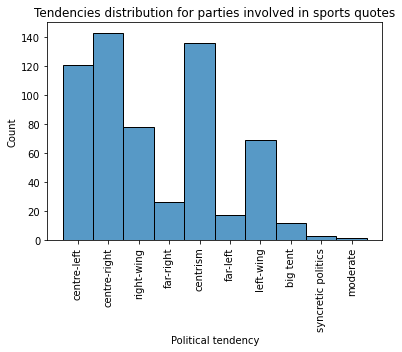

In [42]:
ax = sns.histplot(data=parties_info_tendency, x=0)
ax.set_title('Tendencies distribution for parties involved in sports quotes')
ax.set(xlabel='Political tendency')
ax.tick_params(axis='x', rotation=90)

In [ ]:
# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('speaker_attributes.parquet', columns=['occupation','party','id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID') 

In [ ]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
df['qids'] = df['qids'].str.strip('[\'\']')
politicians = speaker_attributes[speaker_attributes['id'].isin(df['qids'])]

politicians

# Which political parties or politicians are the most present in the sports quotes?

## Parties

In [ ]:
# Only keeping the first qid in the party feature
politicians_1_qid = politicians['current_party']
politicians_1_qid.shape

#OLD TO DELETE
#politicians_1_qid = politicians['party'].str.get(0)
#politicians_1_qid.shape

# Counts the occurences of each party and merging the corresponding label
party_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid))
party_counts_label_1_qid = party_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})
party_counts_label_1_qid.head(3)

In [ ]:
party_counts_label_1_qid.to_csv('party_count.csv', index=False)

In [ ]:
# Setting label of party with count lower than the .99 quantile to 'Others'
threshold_value = party_counts_label_1_qid['count'].quantile(.99)
values_below_thresh = party_counts_label_1_qid['count'] < threshold_value
party_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

In [ ]:
party_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Parties distribution over sport quotes')

In [ ]:
party_counts_label_1_qid.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, figsize=(8, 8), log=False, title='Parties distribution over sport quotes')

## Politicians

In [ ]:
# Only keeping the first qid in the party feature
politicians_1_qid = politicians['id']
politicians_1_qid

# Counts the occurences of each party and merging the corresponding label
politician_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid))
politician_counts_label_1_qid = politician_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'politician': 'count'})
politician_counts_label_1_qid.head(3)


In [ ]:
# Setting label of politician with count lower than the .99 quantile to 'Others'
threshold_value = politician_counts_label_1_qid['count'].quantile(.99)
values_below_thresh = politician_counts_label_1_qid['count'] < threshold_value
politician_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

In [ ]:
politician_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Politicians distribution over sport quotes')

# All sport quotes speakers : occupation distribution

In [ ]:
occupations = []

for i in range(speakers.shape[0]):
    occupations = np.concatenate((occupations, speakers['occupation'].iloc[i]), axis=None)

occupations = pd.DataFrame(occupations, columns=['occupation'])

In [ ]:
# Counts the occurences of each occupation and merging the corresponding label
occupation_counts_1_qid_speakers = pd.DataFrame(pd.value_counts(occupations['occupation']))
occupation_counts_label_1_qid_speakers = occupation_counts_1_qid_speakers.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid_speakers

In [ ]:
# Setting label of occupation with count lower than the .99 quantile to 'Others'
threshold_value = occupation_counts_label_1_qid_speakers['count'].quantile(.99)
values_below_thresh = occupation_counts_label_1_qid_speakers['count'] < threshold_value
occupation_counts_label_1_qid_speakers.loc[values_below_thresh,'Label'] = 'Others'

In [ ]:
# plot
occupation_counts_label_1_qid_speakers.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='All sport quotes speakers occupations')

In [ ]:
# Counts the occurences of each occupation and merging the corresponding label
occupation_counts_1_qid_speakers = pd.DataFrame(pd.value_counts(occupations['occupation']))
occupation_counts_label_1_qid_speakers = occupation_counts_1_qid_speakers.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid_speakers

# Setting label of occupation with political party
values_below_thresh = ~(speakers['party'].isna())
occupation_counts_label_1_qid_speakers.loc[values_below_thresh,'Label'] = 'With political party'

# Setting label of occupation with count lower than the .99 quantile to 'Others'
threshold_value = occupation_counts_label_1_qid_speakers['count'].quantile(.99)
values_below_thresh = occupation_counts_label_1_qid_speakers['count'] < threshold_value
occupation_counts_label_1_qid_speakers.loc[values_below_thresh,'Label'] = 'Others'

In [ ]:
# plot
occupation_counts_label_1_qid_speakers.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='All sport quotes speakers occupations (grouping people with a political party)')

# Politicians : occupation distribution

In [ ]:
politicians['occupation']

In [ ]:
politiciansbis=politicians

In [ ]:
politicians_none_qid = []
politicians_1_qid = []
politicians_many_qid = []

for i in range(politiciansbis.shape[0]):
    if politiciansbis['occupation'].iloc[i] is None:
        politicians_none_qid.append(politiciansbis['occupation'].iloc[i])
    elif len(politiciansbis['occupation'].iloc[i]) == 1 :
           politicians_1_qid.append(politiciansbis['occupation'].iloc[i])
    elif len(politiciansbis['occupation'].iloc[i]) > 1 :
             politicians_many_qid.append(politiciansbis['occupation'].iloc[i])
    else :
             politicians_none_qid.append(politiciansbis['occupation'].iloc[i])

politicians_none_qid = pd.DataFrame(politicians_none_qid, columns=['occupation'])
politicians_1_qid = pd.DataFrame(politicians_1_qid, columns=['occupation'])
#politicians_1_qid

In [ ]:
politicians_many_qid_politician = np.array([])
politicians_many_qid_no_politician = np.array([])
for item in politicians_many_qid :
    if 'Q82955' in item :
        politicians_many_qid_politician = np.concatenate((politicians_many_qid_politician, item), axis=None)
    else : 
        politicians_many_qid_no_politician = np.concatenate((politicians_many_qid_no_politician, item), axis=None)

politicians_many_qid_politician = pd.DataFrame(politicians_many_qid_politician, columns=['occupation'])
politicians_many_qid_no_politician = pd.DataFrame(politicians_many_qid_no_politician, columns=['occupation'])
#politicians_many_qid_politician

In [ ]:
politicians_none_qid

In [ ]:
# Counts the occurences of each occupation and merging the corresponding label FOR 1 OCCUPATION
occupation_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid['occupation']))
occupation_counts_label_1_qid = occupation_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid.head()
occupation_counts_label_1_qid.tail()

# Counts the occurences of each occupation and merging the corresponding label FOR MANY OCCUPATIONS - POLITICIAN
occupation_counts_many_qid_politician = pd.DataFrame(pd.value_counts(politicians_many_qid_politician['occupation']))
occupation_counts_label_many_qid_politician = occupation_counts_many_qid_politician.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_many_qid_politician.head()
occupation_counts_label_many_qid_politician.tail()

# Counts the occurences of each occupation and merging the corresponding label FOR MANY OCCUPATIONS - NO POLITICIAN
occupation_counts_many_qid_no_politician = pd.DataFrame(pd.value_counts(politicians_many_qid_no_politician['occupation']))
occupation_counts_label_many_qid_no_politician = occupation_counts_many_qid_no_politician.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_many_qid_no_politician

In [ ]:
# Setting label of occupation with count lower than the .98 quantile to 'Others'
threshold_value = occupation_counts_label_1_qid['count'].quantile(.98)
values_below_thresh = occupation_counts_label_1_qid['count'] < threshold_value
print(occupation_counts_label_1_qid.loc[values_below_thresh,'Label'])
occupation_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

# Delete politician label because not relevant for the study
occupation_counts_label_many_qid_politician = occupation_counts_label_many_qid_politician[occupation_counts_label_many_qid_politician['Label']!='politician']

# Setting label of occupation with count lower than the .98 quantile to 'Others'
threshold_value = occupation_counts_label_many_qid_politician['count'].quantile(.98)
values_below_thresh = occupation_counts_label_many_qid_politician['count'] < threshold_value
print(occupation_counts_label_many_qid_politician.loc[values_below_thresh,'Label'])
occupation_counts_label_many_qid_politician.loc[values_below_thresh,'Label'] = 'Others'

# Setting label of occupation with count lower than the .98 quantile to 'Others'
threshold_value = occupation_counts_label_many_qid_no_politician['count'].quantile(.98)
values_below_thresh = occupation_counts_label_many_qid_no_politician['count'] < threshold_value
print(occupation_counts_label_many_qid_no_politician.loc[values_below_thresh,'Label'])
occupation_counts_label_many_qid_no_politician.loc[values_below_thresh,'Label'] = 'Others'

In [ ]:
# plot
occupation_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.1f%%', title='Sport quotes speakers with politicial party with single occupation')

In [ ]:
# plot
occupation_counts_label_many_qid_politician.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Sport quotes speakers with politicial party with multiple occupations including politician')

In [ ]:
# plot
occupation_counts_label_many_qid_no_politician.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Sport quotes speakers with politicial party with multiple occupations excluding politician')

# Notes

In [ ]:

#au moins politician comparé à ceux qui reste

#-Would have also been interesting to visualise (as a type negative control) in a more exploratory sense how the # of politicians in sports-related news differs from other speakers that are unrelated to politics. This would be useful to show that trends for the politicians in sports do not follow some baseline trend.


In [ ]:
#Removing speakers without any known party (i.e. with 'party' == None)
#politicians = speakers[~(speakers['party'].isna())]

#politician_qid= qid_labels[qid_labels['Label']=='politician']
#politicians = speakers[politician_qid.index.isin(speakers['occupation'])]